# **RAFT DIVE**

In this notebook we will dive into RAFT, explore how it works, and gain intuition that will allow us to use it with other Advanced Neural Networks.

In [1]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# add RAFT to core path
sys.path.append('RAFT/core')
     
from raft_utils import *

Set savepath for GIFs

In [3]:
GIF_SAVEPATH = r"C:\Users\itber\Documents\utils\gif_maker"

## **Run RAFT on test images**

In [4]:
frame1 = cv2.imread('test_images/fan_frame_1.png')
frame2 = cv2.imread('test_images/fan_frame_2.png')
frame3 = cv2.imread('test_images/fan_frame_3.png') # large displacement

# frame1 = cv2.imread('test_images/fan_frame_61.png')
# frame2 = cv2.imread('test_images/fan_frame_62.png')
# frame3 = cv2.imread('test_images/fan_frame_63.png') # large displacement

frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)

In [5]:
# fig, ax = plt.subplots(1, 2, figsize=(18, 4))
# fig.suptitle("Large Displacement", size=21)
# ax[0].imshow(frame1)
# ax[0].set_title("Frame 20")
# ax[1].imshow(frame2)
# ax[1].set_title("Frame 23");

In [6]:
# load model
model = load_model("RAFT/models/raft-sintel.pth", args=Args())

# predict Optical Flow
flow_iters = inference(model, frame1, frame3, device='cuda', iters=20, test_mode=False)

c:\Users\itber\anaconda3\Lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


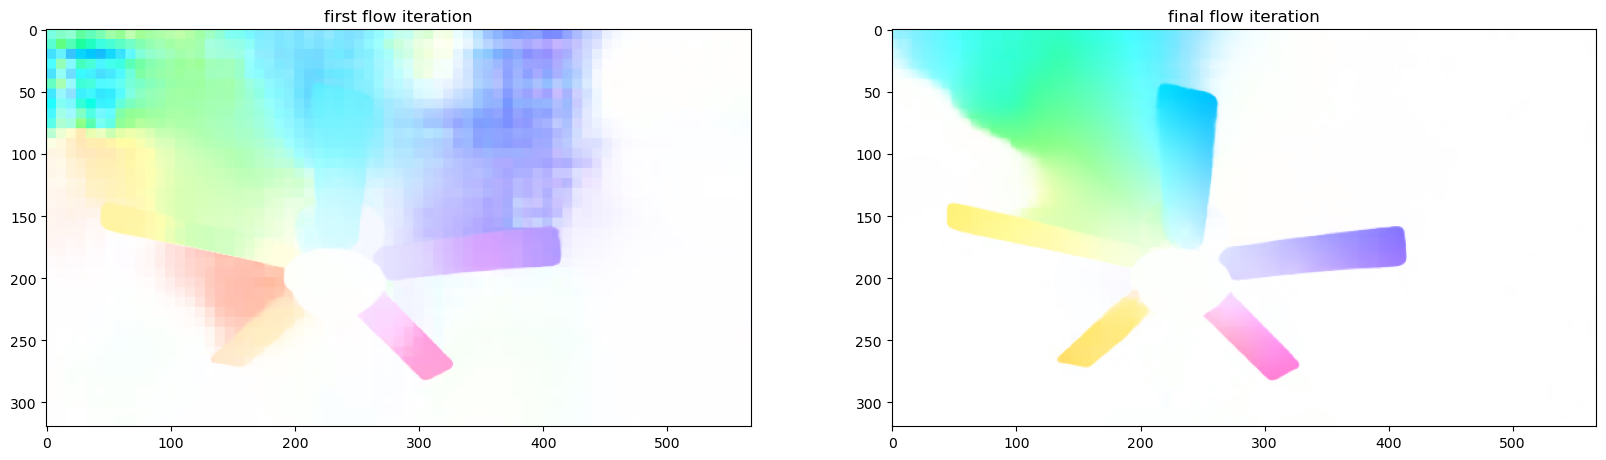

In [7]:
_, (ax0, ax1) = plt.subplots(1,2, figsize=(20,10))

ax0.imshow(get_viz(flow_iters[0]))
ax0.set_title('first flow iteration')
ax1.imshow(get_viz(flow_iters[-1]))
ax1.set_title('final flow iteration');

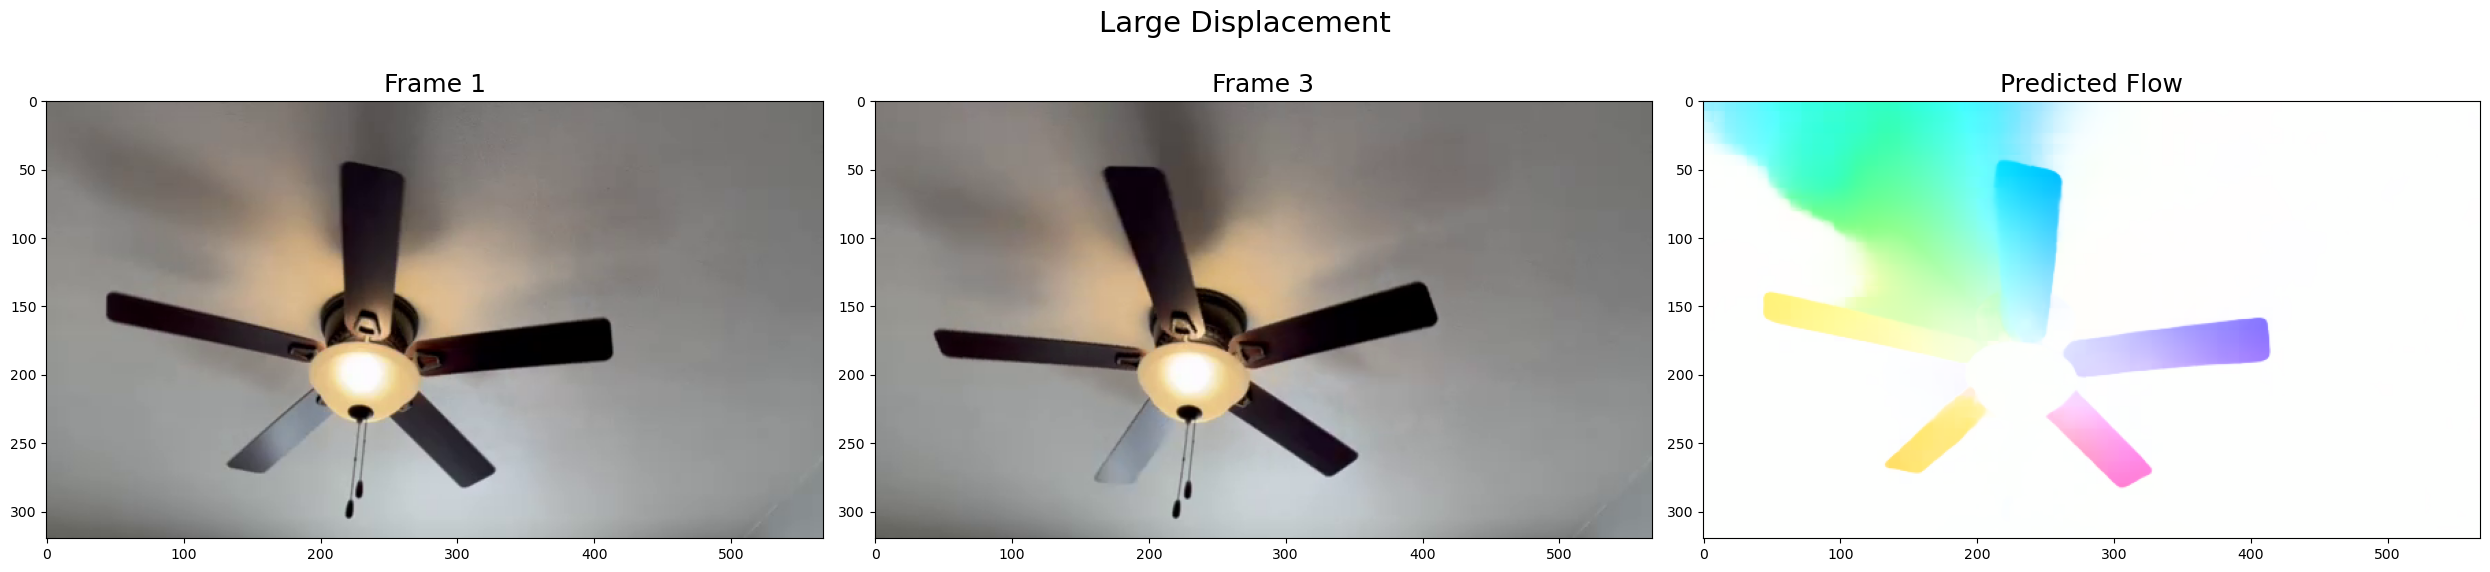

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(25, 6))
fig.suptitle("Large Displacement", size=21)
ax[0].imshow(frame1)
ax[0].set_title("Frame 1", size=18)
ax[1].imshow(frame3)
ax[1].set_title("Frame 3", size=18)
ax[2].imshow(get_viz(flow_iters[-1]))
ax[2].set_title("Predicted Flow", size=18);

fig.tight_layout();

Get test pixels places of high, low, and medium flow

In [20]:
flow = flow_iters[-1].squeeze(0).cpu().numpy()
abs_flow = np.abs(flow)

# highest abs flow in each direction
hi_flow_1 = np.where(abs_flow == abs_flow[0, :, :].max()) # u - horizontal
hi_flow_2 = np.where(abs_flow == abs_flow[1, :, :].max()) # v - vertical

# lowest abs flow in each direction
lo_flow_1 = np.where(abs_flow == abs_flow[0, :, :].min()) # u - horizontal
lo_flow_2 = np.where(abs_flow == abs_flow[1, :, :].min()) # v - vertical

# mean abs flow in each direction
me_flow_1 = np.where((abs_flow <= abs_flow[0, :, :].mean() + 1e-4)
                     & (abs_flow >= abs_flow[0, :, :].mean() - 1e-4)) 
me_flow_2 = np.where((abs_flow <= abs_flow[1, :, :].mean() + 1e-4)
                     & (abs_flow >= abs_flow[1, :, :].mean() - 1e-4)) 


lo_flow_1 = np.dstack(lo_flow_1).squeeze()
lo_flow_2 = np.dstack(lo_flow_2).squeeze()

hi_flow_1 = np.dstack(hi_flow_1).squeeze()
hi_flow_2 = np.dstack(hi_flow_2).squeeze()

# me_flow_1 = np.dstack(me_flow_1).squeeze()[0]
# me_flow_2 = np.dstack(me_flow_2).squeeze()[0]

In [21]:
me_flow_1

(array([1], dtype=int64), array([242], dtype=int64), array([277], dtype=int64))

In [22]:
me_flow_2

(array([0, 0, 1], dtype=int64),
 array([ 29, 238, 102], dtype=int64),
 array([270, 162, 255], dtype=int64))

## **RUN Test inference of RAFT**

### Get Test pixel

NOTE: For the test pixel we only consider the most extreme horizontal or the most extreme vertical pixel displacements

In [23]:
frame1.shape

(320, 568, 3)

In [24]:
320/8, 568/8

(40.0, 71.0)

### Get Test Pixels

In [25]:
flow_locs = [hi_flow_1, hi_flow_2, np.array([0, 175, 405])]


flow_locs = [np.array([0, 60, 260]), # with frame 2, this has multiple descent directions and chooses the closest one!
             np.array([0, 175, 405]),
             np.array([0, 275, 315])
             # np.array([0, 270, 320])
            # np.array([0, 173, 215])
             ]

### Select Test Pixel

In [26]:
frame1.shape

(320, 568, 3)

In [27]:
# get test pixel
pix = 0

test_pixel = flow_locs[pix]

flow_at_tp = flow_iters[-1].cpu().squeeze(0)[:, test_pixel[1], test_pixel[2]]

print(f"test pixel: {test_pixel} - flow at test pixel: {flow_at_tp}")

test pixel: [  0  60 260] - flow at test pixel: tensor([-49.4194,  -4.3882])


### Display All test pixels

In [28]:
# predict Optical Flow
model_outputs = test_inference(model, frame1, frame3, device='cuda', iters=20, test_pixel=test_pixel, test_mode=True)
features, test_responses, motion_features, hidden_states, flow_low, flow_up = model_outputs

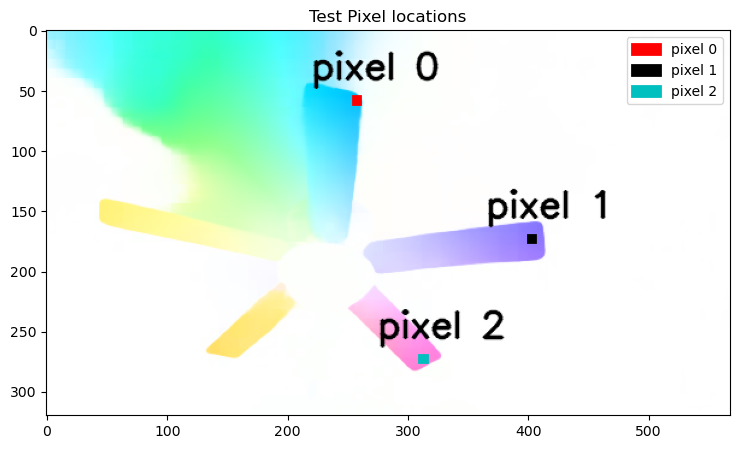

In [29]:
import matplotlib.patches as patches

flow_viz = get_viz(flow_up)


_, ax = plt.subplots(1, 1, figsize=(10, 5))


colors = ['r', 'k', 'c', 'b']
for i, (c, loc) in enumerate(zip(colors, flow_locs)):
    rect = patches.Rectangle(loc[1:][::-1] - 5.5, 6, 6, linewidth=2, edgecolor=c, facecolor=c, label=f"pixel {i}")
    ax.add_patch(rect)

    flow_viz = cv2.putText(flow_viz, f"pixel {i}", loc[1:][::-1] - np.array([40, 20]), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    # get flow at test pixel
    flow = flow_iters[-1].cpu().squeeze(0)[:, loc[1], loc[2]]



ax.imshow(flow_viz)

ax.set_title("Test Pixel locations");
ax.legend()

## **Inspect Feature Maps**

In [30]:
fmap1, fmap2, hiddn, cntxt = features

fmap1 = fmap1.squeeze(0).cpu().numpy()
fmap2 = fmap2.squeeze(0).cpu().numpy()
hiddn = hiddn.squeeze(0).cpu().numpy()
cntxt = cntxt.squeeze(0).cpu().numpy()

In [31]:
fmap1.shape, fmap2.shape, hiddn.shape, cntxt.shape

((256, 40, 71), (256, 40, 71), (128, 40, 71), (128, 40, 71))

In [ ]:
for i in range(128):

    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle(f"Extracted Feature maps - Iter: {i}", size=18, weight=10);
    ax[0][0].imshow(fmap1[i, :, :])
    ax[0][0].set_title("fmap 1")

    ax[0][1].imshow(fmap2[i, :, :])
    ax[0][1].set_title("fmap 2")

    ax[1][0].imshow(hiddn[i, :, :])
    ax[1][0].set_title("Hidden")

    ax[1][1].imshow(cntxt[i, :, :])
    ax[1][1].set_title("Context");

    plt.tight_layout()

    
    fig.savefig(os.path.join(GIF_SAVEPATH, f"extracted_features\\extracted_features_iter_0000{i}"));
    plt.close();

## **Inspect Test Responses**

In [40]:
itr = 0
lvl = 0

### Display correlation response at Test Pixel

In [41]:
# get pixel location
pixel_loc = test_responses[itr][lvl][2]
pixel_loc

array([32.,  8.], dtype=float32)

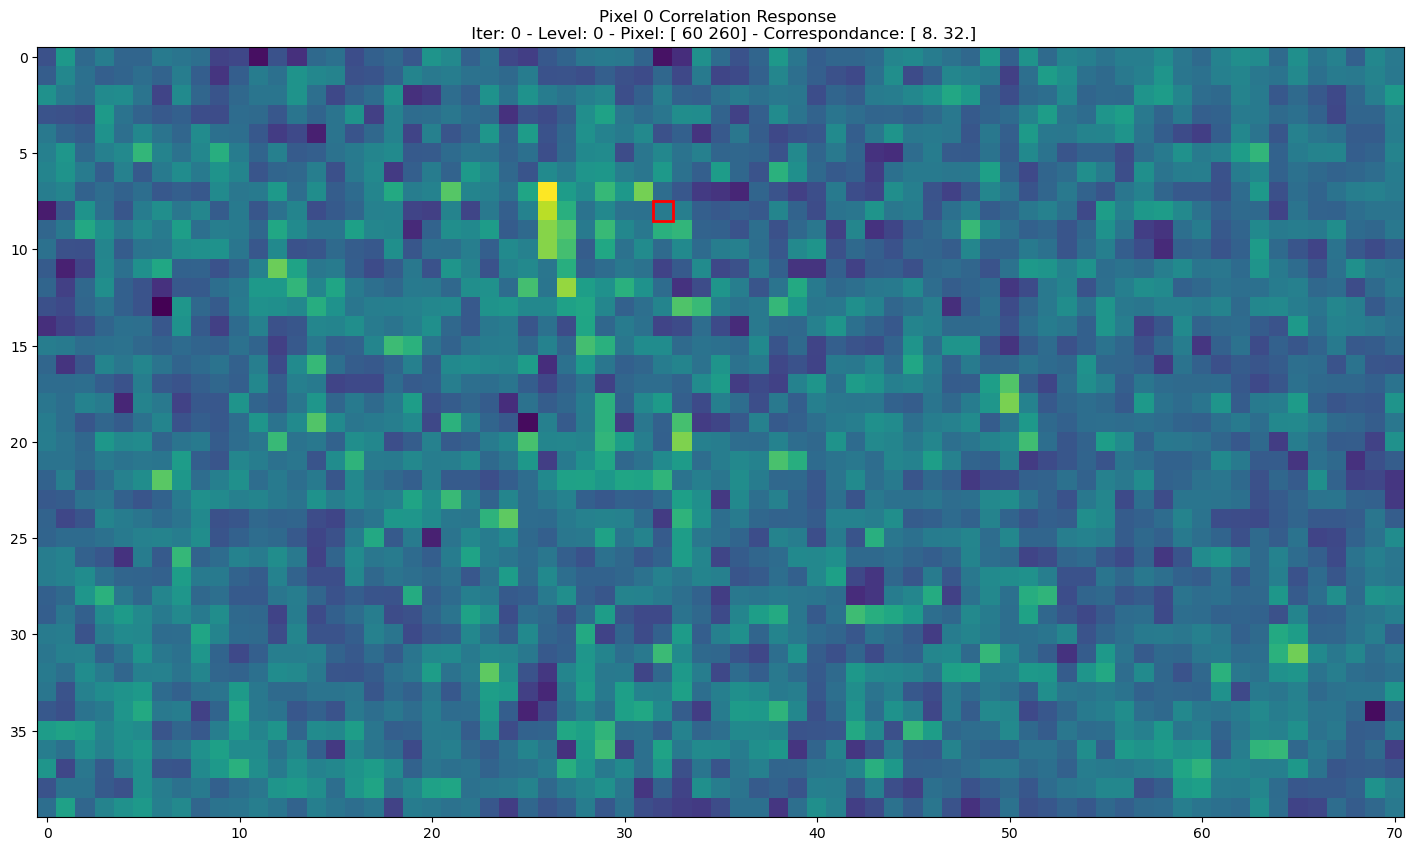

In [42]:
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.imshow(test_responses[itr][lvl][0]);
ax.set_title(f"Pixel {pix} Correlation Response \n "
             + f"Iter: {itr} - Level: {lvl} - Pixel: {test_pixel[1:]} - Correspondance: {pixel_loc.round(2)[::-1]}");

# mark I2 pixel under test
rect = patches.Rectangle(pixel_loc - 0.5, 1, 1, linewidth=2, edgecolor='r', facecolor='none')
# rect = patches.Rectangle(pixel_loc - (0.5/(2**lvl)), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)

# TEMP: draw arrow for display
# plt.arrow(pixel_loc.astype(int)[0] - 1, pixel_loc.astype(int)[1] + 2, 4, 0, linewidth=2, head_width=1, edgecolor='r', facecolor='r') # p0
# plt.arrow(pixel_loc.astype(int)[0] - 3, pixel_loc.astype(int)[1] + 2, 0, -3, linewidth=2, head_width=1, edgecolor='r', facecolor='r') # p1
# plt.arrow(pixel_loc.astype(int)[0] - 3, pixel_loc.astype(int)[1] - 0, 0, 3, linewidth=2, head_width=1, edgecolor='r', facecolor='r') # p2


plt.show();
# fig.savefig(f"C:\\Users\\itber\\Documents\\utils\\gif_maker\pixel{pix}\\pixel_lvl{lvl}_iter{itr}");

## Get Zoomed pixel location and Resampled Grid

In [36]:
r = 4
u = slice(int(pixel_loc[0] - r), int(pixel_loc[0] + r + 1)) # horizontal
v = slice(int(pixel_loc[1] - r), int(pixel_loc[1] + r + 1)) # vertical

u = slice(int(np.clip(pixel_loc[0] - r, 0, np.infty)), int(np.clip(pixel_loc[0] + r + 1, 0, np.infty)))
v = slice(int(np.clip(pixel_loc[1] - r, 0, np.infty)), int(np.clip(pixel_loc[1] + r + 1, 0, np.infty)))

zoomed_response = test_responses[itr][lvl][0][v, u]
bilres_response = test_responses[itr][lvl][1].T

## NEEDS UPDATE FOR ALL CASES 
# add zero padding for display
delta = zoomed_response.shape[0] - zoomed_response.shape[1]

if delta < 0:
    zoomed_response = np.vstack(( zoomed_response, np.zeros((abs(delta), (2*r) + 1)) ))
# FILL IN REST OF CASES HERE

# rescale for consistent visibility
zoomed_response = cv2.normalize(zoomed_response, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
bilres_response = cv2.normalize(bilres_response, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

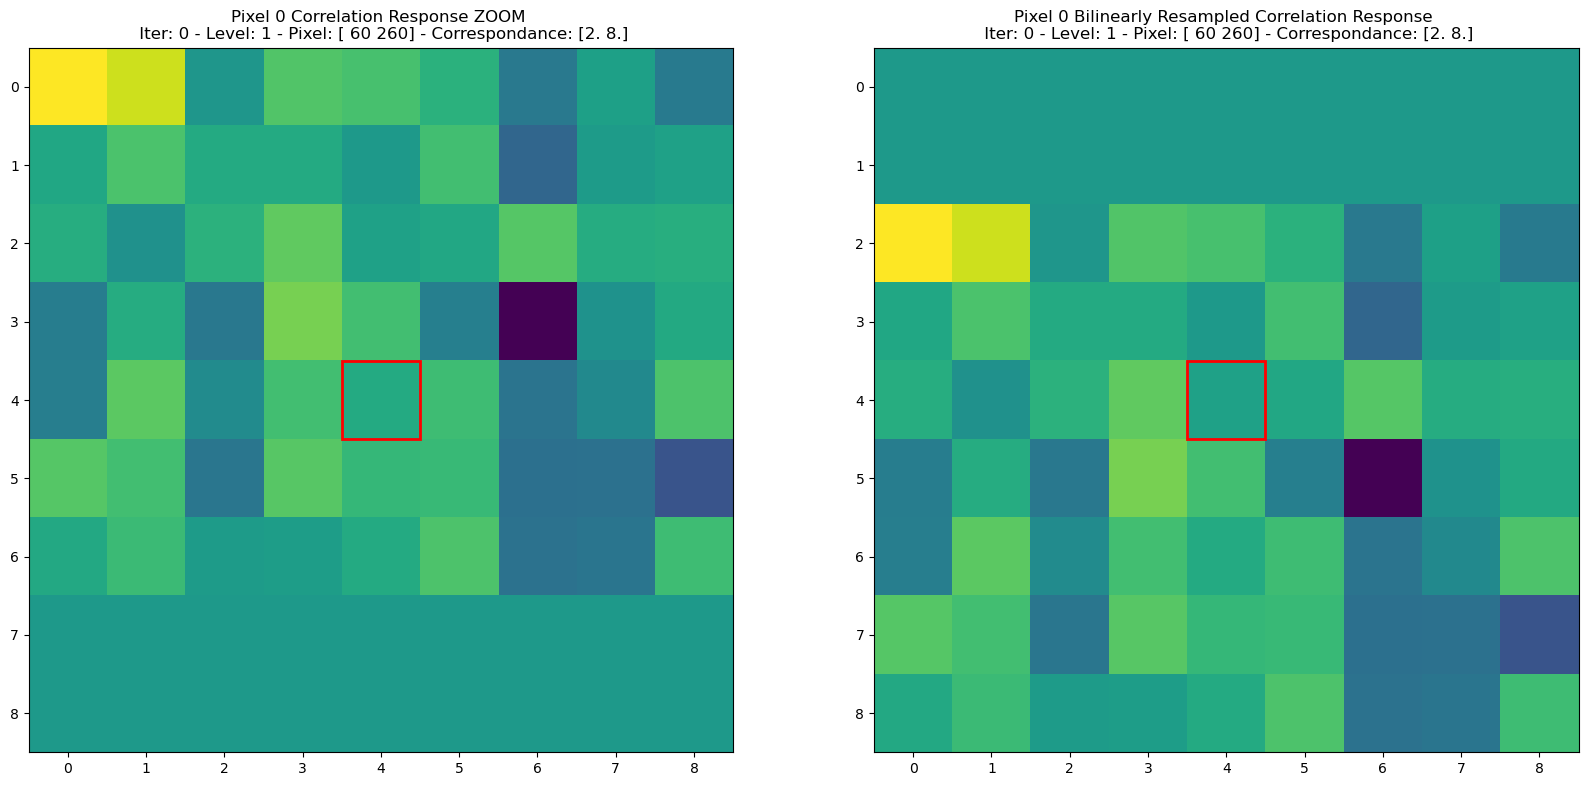

In [39]:
_, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(zoomed_response);
ax[0].set_title(f"Pixel {pix} Correlation Response ZOOM \n "
             + f"Iter: {itr} - Level: {lvl} - Pixel: {test_pixel[1:]} - Correspondance: {pixel_loc.round(2)[::-1]}");
# mark I2 pixel under test
rect = patches.Rectangle((r + (pixel_loc % 1) - 0.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax[0].add_patch(rect)


ax[1].imshow(bilres_response);
ax[1].set_title(f"Pixel {pix} Bilinearly Resampled Correlation Response \n "
             + f"Iter: {itr} - Level: {lvl} - Pixel: {test_pixel[1:]} - Correspondance: {pixel_loc.round(2)[::-1]}");

# mark I2 pixel under test
rect = patches.Rectangle((3.5, 3.5), 1, 1, linewidth=2, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)

In [1004]:
np.round(zoomed_response, 3)

array([[0.371, 0.272, 0.193, 0.473, 0.256, 0.085, 0.137, 0.11 , 0.241],
       [0.139, 0.27 , 0.246, 0.335, 0.324, 0.181, 0.135, 0.157, 0.068],
       [0.27 , 0.155, 0.237, 0.258, 0.457, 0.383, 0.388, 0.409, 0.769],
       [0.445, 0.401, 0.026, 0.179, 0.329, 0.342, 0.605, 1.   , 0.853],
       [0.249, 0.349, 0.245, 0.301, 0.144, 0.199, 0.381, 0.396, 0.133],
       [0.346, 0.182, 0.235, 0.283, 0.298, 0.257, 0.068, 0.039, 0.281],
       [0.258, 0.   , 0.115, 0.108, 0.429, 0.199, 0.246, 0.354, 0.437],
       [0.144, 0.298, 0.327, 0.217, 0.243, 0.185, 0.104, 0.35 , 0.184],
       [0.285, 0.238, 0.175, 0.294, 0.414, 0.206, 0.098, 0.205, 0.266]],
      dtype=float32)

At iteration 1, the bilinear resampling should be the same since there is no optical flow. (Unless we warm start with previous flow)

## **Inspect the Motion Features**

In [29]:
motion_features[itr].shape

torch.Size([1, 128, 40, 71])

In [30]:
m_feats = motion_features[itr].squeeze(0).cpu().numpy()

In [ ]:
for i in range(20):
    m_feats = motion_features[i].squeeze(0).cpu().numpy()
    
    fig, ax = plt.subplots(2, 3, figsize=(16, 7))
    fig.suptitle(f"Motion Features - Iter: {i}", size=18, weight=10);
    ax[0][0].imshow(m_feats[20, :, :])
    ax[0][0].set_title("Motion Feature: 20")

    ax[1][0].imshow(m_feats[48, :, :])
    ax[1][0].set_title("Motion Feature: 48")

    ax[0][1].imshow(m_feats[49, :, :])
    ax[0][1].set_title("Motion Feature: 49")

    ax[1][1].imshow(m_feats[121, :, :])
    ax[1][1].set_title("Motion Feature: 121")

    ax[0][2].imshow(m_feats[126, :, :])
    ax[0][2].set_title("Motion Feature: 126")

    ax[1][2].imshow(m_feats[127, :, :])
    ax[1][2].set_title("Motion Feature: 127");

    plt.tight_layout();


    fig.savefig(os.path.join(GIF_SAVEPATH, r"motion_features\\motion_feats_iter_0000{i}"));
    plt.close();

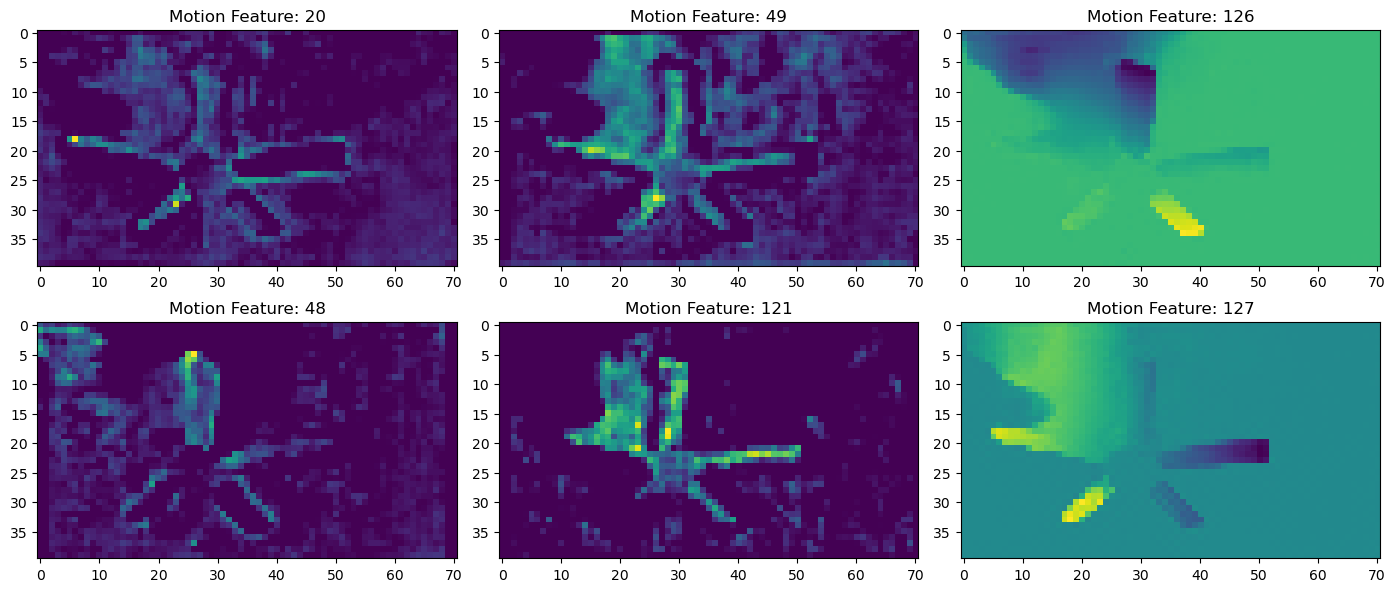

In [ ]:
m_feats = motion_features[15].squeeze(0).cpu().numpy()

fig, ax = plt.subplots(2, 3, figsize=(14, 6))
ax[0][0].imshow(m_feats[20, :, :])
ax[0][0].set_title("Motion Feature: 20")

ax[1][0].imshow(m_feats[48, :, :])
ax[1][0].set_title("Motion Feature: 48")

ax[0][1].imshow(m_feats[49, :, :])
ax[0][1].set_title("Motion Feature: 49")

ax[1][1].imshow(m_feats[121, :, :])
ax[1][1].set_title("Motion Feature: 121")

ax[0][2].imshow(m_feats[126, :, :])
ax[0][2].set_title("Motion Feature: 126")

ax[1][2].imshow(m_feats[127, :, :])
ax[1][2].set_title("Motion Feature: 127");

plt.tight_layout();


In [1040]:
# for i in range(20):
#     m_feats = motion_features[i].squeeze(0).cpu().numpy()

#     for j in range(m_feats.shape[0]):
#         fig = plt.figure(figsize=(20, 10))
#         plt.imshow(m_feats[j, :, :])
#         plt.title(f"Motion Feature: {j} - Iteration - {i}")

#         fig.savefig(f"C:\\Users\\itber\\Documents\\utils\\gif_maker\\motion_features\\motion_feats_iter_0000{i}_{j}");
#         plt.close();
    

## **Inspect the hidden states**

In [24]:
hidden_states[0].shape

torch.Size([1, 128, 55, 128])

In [26]:
hid_states = hidden_states[0].squeeze(0).cpu().numpy()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 6))
ax[0][0].imshow(hid_states[0, :, :])
ax[0][0].set_title("Hidden State: 0")

ax[0][1].imshow(hid_states[10, :, :])
ax[0][1].set_title("Hidden State: 10")

ax[1][0].imshow(hid_states[50, :, :])
ax[1][0].set_title("Hidden State: 50")

ax[1][1].imshow(hid_states[100, :, :])
ax[1][1].set_title("Hidden State: 100");

In [36]:
for i in range(20):

    # plt.figure(figsize=(8, 4))
    # plt.imshow(hid_states[i, :, :])
    # plt.title(f"Hidden State: {i}")

    h_states = hidden_states[i].squeeze(0).cpu().numpy()

    fig, ax = plt.subplots(2, 2, figsize=(12, 6))
    ax[0][0].imshow(h_states[0, :, :])
    ax[0][0].set_title(f"Hidden State: 0 - iter: {i}")

    ax[0][1].imshow(h_states[10, :, :])
    ax[0][1].set_title(f"Hidden State: 10 - iter: {i}")

    ax[1][0].imshow(h_states[50, :, :])
    ax[1][0].set_title(f"Hidden State: 50 - iter: {i}")

    ax[1][1].imshow(h_states[100, :, :])
    ax[1][1].set_title(f"Hidden State: 100 - iter: {i}");


    fig.savefig(os.path.join(GIF_SAVEPATH, r"frames_6\\hidden_state_{i}"));
    plt.close();

Text(0.5, 1.0, 'Hidden State: 19')

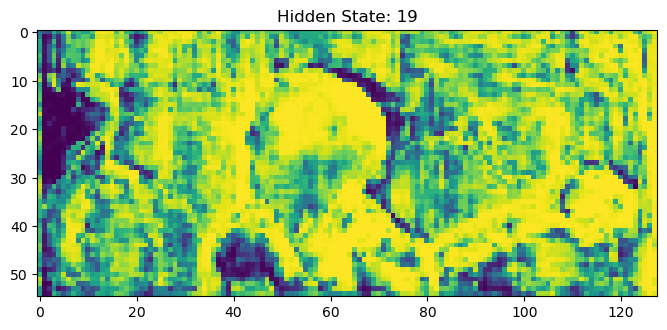

In [34]:
plt.figure(figsize=(8, 4))
plt.imshow(hid_states[i, :, :])
plt.title(f"Hidden State: {i}")